In [1]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline
from os import listdir
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import cross_val_score
from keras.layers import Dense, Flatten
from keras import Model
import wandb
from wandb.keras import WandbCallback


Using TensorFlow backend.
wandb: WARNING Keras version 2.3.1 is not fully supported. Required keras >= 2.4.0


In [2]:
path = "Images/"
list_photos = [file for file in listdir(path)]
print(len(list_photos))
im = pd.read_csv('im1.csv')

1050


In [3]:
dic= {'HomeFurnishing':0, 'KitchenDining':1, 'HomeDecorFestiveNeeds':2, 'Computers':3, 'Watches':4, 'BeautyandPersonalCare':5, 'BabyCare':6 }
data = pd.DataFrame()
data["image_path"] = path + im['image']
data["target_name"] = im["target"]
data["target"] = im['target'].map(dic)
data

,image_path,target_name,target
0,Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg,HomeFurnishing,0
1,Images/7b72c92c2f6c40268628ec5f14c6d590.jpg,BabyCare,6
2,Images/64d5d4a258243731dc7bbb1eef49ad74.jpg,BabyCare,6
3,Images/d4684dcdc759dd9cdf41504698d737d8.jpg,HomeFurnishing,0
4,Images/6325b6870c54cd47be6ebfbffa620ec7.jpg,HomeFurnishing,0
...,...,...,...
1045,Images/958f54f4c46b53c8a0a9b8167d9140bc.jpg,BabyCare,6
1046,Images/fd6cbcc22efb6b761bd564c28928483c.jpg,BabyCare,6
1047,Images/5912e037d12774bb73a2048f35a00009.jpg,BabyCare,6
1048,Images/c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,BabyCare,6


## Transfert Learning VGG16

In [4]:
vgg16 = VGG16(weights='imagenet',include_top=False,input_shape = (224, 224, 3))
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:

# Freeze existing VGG already trained weights
for layer in vgg16.layers:
    layer.trainable = False


In [6]:
out = vgg16.output

In [7]:
#preparation du CNN
x = Flatten()(out)
x = Dense(7, activation='softmax')(x)

In [8]:
model = Model(inputs=vgg16.input, outputs=x)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])


In [9]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [10]:
data.head()

,image_path,target_name,target
0,Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg,HomeFurnishing,0
1,Images/7b72c92c2f6c40268628ec5f14c6d590.jpg,BabyCare,6
2,Images/64d5d4a258243731dc7bbb1eef49ad74.jpg,BabyCare,6
3,Images/d4684dcdc759dd9cdf41504698d737d8.jpg,HomeFurnishing,0
4,Images/6325b6870c54cd47be6ebfbffa620ec7.jpg,HomeFurnishing,0


In [11]:
X_train, X_test, y_train, y_test = train_test_split(data['image_path'], data['target'], test_size = 0.3)

In [12]:
# One hot encode ouput
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [13]:
y_test # convertir en liste peut etre ...

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [14]:
#charger le images
X_train_list = []

for image_num in X_train :

    img = keras.preprocessing.image.load_img(image_num, target_size=(224, 224))
    img = img_to_array(img)
    X_train_list.append(img)

C:\Anaconda\envs\keras_env\lib\site-packages\PIL\Image.py:2914: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [15]:
X_test_list = []

for image_num in X_test :

    img = keras.preprocessing.image.load_img(image_num, target_size=(224, 224))
    img = img_to_array(img)
    X_test_list.append(img)

In [16]:
#normaliser les pixels entre 0 et 1
X_train = np.array( X_train_list, dtype="float") / 255.0
X_test = np.array( X_test_list, dtype="float") / 255.0

In [17]:
#initialisation de la classe ImageDataGenerator
train_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

test_datagen = ImageDataGenerator()

In [18]:
#création de train_generator, valid_generator et test_generator
batch_size = 8
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
valid_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, batch_size=1)

In [19]:
wandb.init(project="transfer learning modele1", name = 'vgg16')
model.fit_generator(train_generator, validation_data=valid_generator,
 steps_per_epoch=len(X_train) // batch_size,
 epochs=5, callbacks=[WandbCallback()])

wandb: Currently logged in as: agar (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/5
91/91 [==============================] - 428s 5s/step - loss: 0.3667 - accuracy: 0.8736 - val_loss: 0.1615 - val_accuracy: 0.9258
Epoch 2/5
91/91 [==============================] - 390s 4s/step - loss: 0.2516 - accuracy: 0.9129 - val_loss: 0.2952 - val_accuracy: 0.9318
Epoch 3/5
91/91 [==============================] - 384s 4s/step - loss: 0.2672 - accuracy: 0.9122 - val_loss: 0.0634 - val_accuracy: 0.9434
Epoch 4/5
91/91 [==============================] - 367s 4s/step - loss: 0.1949 - accuracy: 0.9334 - val_loss: 0.0808 - val_accuracy: 0.9475
Epoch 5/5
91/91 [==============================] - 348s 4s/step - loss: 0.2000 - accuracy: 0.9371 - val_loss: 0.1435 - val_accuracy: 0.9574


In [20]:
#Evaluer le modèle
score = model.evaluate_generator(valid_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.36772724986076355
Test accuracy: 0.9566571712493896


In [21]:
predict = model.predict_generator(test_generator)
# predict the class label
y_classes = predict.argmax(axis=-1)

## Transfert Learning Xception

In [22]:
from keras.applications import Xception
from keras.applications.xception import preprocess_input

In [23]:
Xcep = Xception(weights='imagenet', include_top=False,pooling = 'avg', input_shape=(299, 299,3))
Xcep.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [24]:
# Freeze existing VGG already trained weights
for layer in Xcep.layers:
    layer.trainable = False
out = Xcep.output

In [25]:
#preparation du CNN
#x = Flatten()(out)
x=out
x = Dense(7, activation='softmax')(x)

modelX = Model(inputs=Xcep.input, outputs=x)
modelX.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])
modelX.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data['image_path'], data['target'], test_size = 0.3)
# One hot encode ouput
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
#charger le images
X_train_list = []

for image_num in X_train :

    img = keras.preprocessing.image.load_img(image_num, target_size=(299, 299))
    img = img_to_array(img)
    X_train_list.append(img)
X_test_list = []

for image_num in X_test :

    img = keras.preprocessing.image.load_img(image_num, target_size=(299, 299))
    img = img_to_array(img)
    X_test_list.append(img)
#normaliser les pixels entre 0 et 1
X_train = np.array( X_train_list, dtype="float") / 255.0
X_test = np.array( X_test_list, dtype="float") / 255.0

In [27]:
#initialisation de la classe ImageDataGenerator
train_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

test_datagen = ImageDataGenerator()

In [28]:
#création de train_generator, valid_generator et test_generator
batch_size = 8
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
valid_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, batch_size=1)

In [29]:
wandb.init(project="transfer learning modele1", name = 'xception')
modelX.fit_generator(train_generator, validation_data=valid_generator,
 steps_per_epoch=len(X_train) // batch_size,
 epochs=5, callbacks=[WandbCallback()])

epoch,4
val_loss,0.14351
val_accuracy,0.95743
loss,0.20026
accuracy,0.93712
_runtime,1932
_timestamp,1629825005
_step,4
best_val_loss,0.0634
best_epoch,2


epoch,▁▃▅▆█
val_loss,▄█▁▂▃
val_accuracy,▁▂▅▆█
loss,█▃▄▁▁
accuracy,▁▅▅██
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/5
91/91 [==============================] - 634s 7s/step - loss: 0.2924 - accuracy: 0.8876 - val_loss: 0.0625 - val_accuracy: 0.9343
Epoch 2/5
91/91 [==============================] - 607s 7s/step - loss: 0.1713 - accuracy: 0.9393 - val_loss: 0.0700 - val_accuracy: 0.9489
Epoch 3/5
91/91 [==============================] - 576s 6s/step - loss: 0.1437 - accuracy: 0.9479 - val_loss: 0.0884 - val_accuracy: 0.9500
Epoch 4/5
91/91 [==============================] - 562s 6s/step - loss: 0.1300 - accuracy: 0.9546 - val_loss: 0.2423 - val_accuracy: 0.9580
Epoch 5/5
91/91 [==============================] - 559s 6s/step - loss: 0.1248 - accuracy: 0.9531 - val_loss: 0.2400 - val_accuracy: 0.9644


In [30]:
#Evaluer le modèle
score = modelX.evaluate_generator(valid_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1552395522594452
Test accuracy: 0.9667638540267944


(array([0, 1]), [Text(0, 0, 'VGG16'), Text(1, 0, 'Xception')])

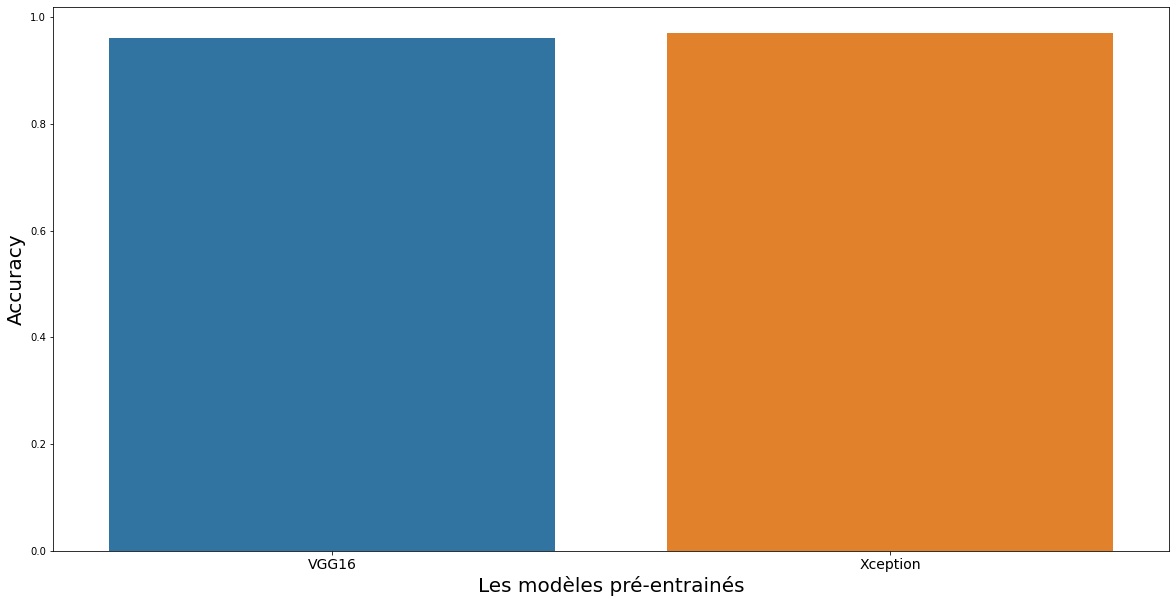

In [31]:
plt.figure(figsize = (20,10))
sns.barplot(x=['VGG16','Xception'], y=[0.96,0.97])
plt.xlabel("Les modèles pré-entrainés", fontsize=20)
plt.ylabel("Accuracy", fontsize = 20)
plt.xticks(fontsize = 14)